In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
import re
import string
from tqdm import tqdm
import numpy as np
import os 
import gensim
from gensim.models import KeyedVectors
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import text_dataset_from_directory   # type: ignore
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Đọc DATA và kiểm tra độ lệch của DATA 

In [2]:
path_train = "DATA/data_train/data_train/train"
path_val = "DATA/data_train/data_train/test"
path_test = "DATA/data_test/data_test/test"


train_df = text_dataset_from_directory(path_train,
                                     batch_size=64,
                                     shuffle=True,
                                     seed=123)

val_df = text_dataset_from_directory(path_val,
                                   batch_size=64,
                                   shuffle=False,
                                   seed=123)

test_df = text_dataset_from_directory(path_test,
                                    batch_size=64,
                                    shuffle=False,
                                    seed=123)


print(train_df.class_names, val_df.class_names, test_df.class_names)
print(len(train_df), len(val_df), len(test_df))

Found 30000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
['neg', 'pos'] ['neg', 'pos'] ['neg', 'pos']
469 157 157


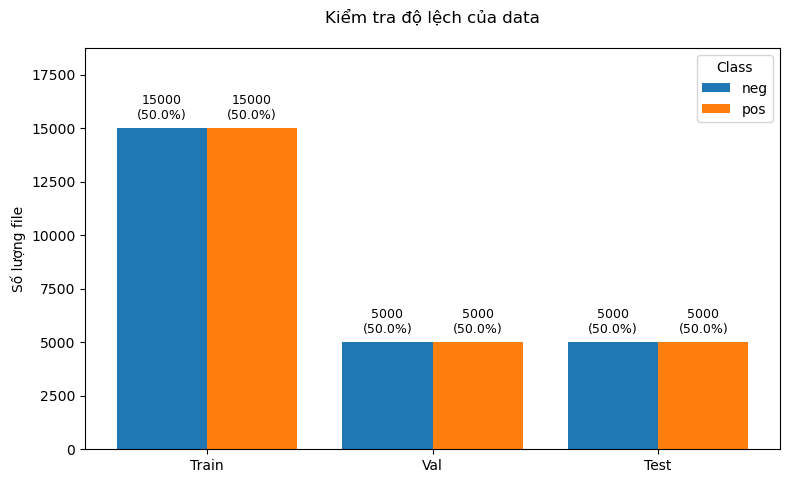

In [3]:
def plot_split_grouped_by_class(base_dir,
                                train_name="train",
                                val_name="test",
                                test_name="test",
                                ext_filter=('.txt',)):
    base = Path(base_dir)
    train_dir = base / "data_train" / "data_train" / train_name
    val_dir   = base / "data_train" / "data_train" / val_name
    test_dir  = base / "data_test"  / "data_test"  / test_name

    def discover_classes(*dirs):
        classes = set()
        for d in dirs:
            if d.exists() and d.is_dir():
                for p in d.iterdir():
                    if p.is_dir():
                        classes.add(p.name)
        ordered = []
        for c in ('neg', 'pos', 'negative', 'positive'):
            if c in classes:
                ordered.append(c)
        # thêm các lớp còn lại
        for c in sorted(classes):
            if c not in ordered:
                ordered.append(c)
        return ordered

    classes = discover_classes(train_dir, val_dir, test_dir)
    if len(classes) == 0:
        print("Không tìm thấy lớp (class) nào. Kiểm tra đường dẫn.")
        return

    def count_in_dir(dir_path, cls):
        p = Path(dir_path) / cls
        if not p.exists():
            return 0
        if ext_filter is None:
            return sum(1 for _ in p.rglob('*') if _.is_file() and not _.name.startswith('.'))
        else:
            return sum(1 for _ in p.rglob('*') if _.is_file() and _.suffix.lower() in ext_filter and not _.name.startswith('.'))

    splits_dirs = [("Train", train_dir), ("Val", val_dir), ("Test", test_dir)]
    counts = []
    for name, d in splits_dirs:
        row = [count_in_dir(d, c) for c in classes]
        counts.append(row)
    counts = np.array(counts)  

    split_totals = counts.sum(axis=1)

    n_splits = counts.shape[0]
    n_classes = counts.shape[1]
    x = np.arange(n_splits)
    width = 0.8 / max(1, n_classes)

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = []
    for j in range(n_classes):
        offsets = x - 0.4 + (j + 0.5) * width
        b = ax.bar(offsets, counts[:, j], width, label=classes[j])
        bars.append(b)

    max_height = int(counts.max() if counts.size else 0)
    top_margin_factor = 1.25
    ax.set_ylim(0, max(1, int(max_height * top_margin_factor)))

    for j, bset in enumerate(bars):
        for i, bar in enumerate(bset):
            h = int(bar.get_height())
            total = split_totals[i]
            pct = (h / total * 100.0) if total > 0 else 0.0
            offset = max(1, int(max_height * 0.02))
            ax.text(bar.get_x() + bar.get_width()/2., h + offset,
                    f"{h}\n({pct:.1f}%)",
                    ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels([s for s, _ in splits_dirs])
    ax.set_ylabel("Số lượng file")
    ax.set_title("Kiểm tra độ lệch của data", pad=18)
    ax.legend(title="Class")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

plot_split_grouped_by_class("DATA")


In [4]:
import random
path_0 = 'DATA/data_train/data_train/train'
path_1 = random.choice(os.listdir(path_0))
path_2 = random.randint(0, len(train_df)*32)
path_3 = '.txt'

path = path_0 + '/' + path_1 + '/' + str(path_2) + path_3
print(path)

if os.path.exists(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    print(lines[0])
else:
    print("File không tồn tại:", path)

DATA/data_train/data_train/train/neg/1536.txt
mình ăn được một thời_gian lâu , giờ mới fb , nhưng có gì đấy sai sai . Hôm đi đến đúng địa_chỉ rồi thì thấy hàng này , vào gọi đồ thì nhìn hoa không có thanh_long đỏ T . T mác nhìn cũn không phải lak lak , bơ hôm đấy hơi đắng , chân trâu cứng , hoa_quả nhạt ,



In [5]:
df = pd.read_csv('DATA/Tweets.csv')
df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
10265,569429468781150208,negative,1.000,Customer Service Issue,1.0000,US Airways,NaN,pmj1234,NaN,0,@USAirways on hold for 2 hours now have been c...,NaN,2015-02-22 01:32:19 -0800,NaN,NaN
10239,569467550100267008,negative,1.000,Flight Booking Problems,0.6540,US Airways,NaN,jednell,NaN,0,"@USAirways OK, I guess the weather has been ro...",NaN,2015-02-22 04:03:38 -0800,NaN,NaN
4333,570304178314190848,negative,1.000,Bad Flight,0.6784,Southwest,NaN,tonybrancato,NaN,0,@SouthwestAir my wife had been in group A in p...,"[41.1974934, -73.76920486]",2015-02-24 11:28:06 -0800,Chappaqua NY,Eastern Time (US & Canada)
12755,570036187815149570,negative,0.657,Bad Flight,0.3548,American,NaN,rkaradi,NaN,0,@AmericanAir ok makes no sense tho Since you'l...,NaN,2015-02-23 17:43:12 -0800,NaN,NaN
980,569979211722596353,negative,1.000,Can't Tell,0.6804,United,NaN,CoffeeCult448,NaN,0,@united I think DM would be better,NaN,2015-02-23 13:56:48 -0800,Buffalo/Oakland/Savannah/Ire,NaN


In [6]:
df['airline_sentiment'].value_counts(),len(df)

(airline_sentiment
 negative    9178
 neutral     3099
 positive    2363
 Name: count, dtype: int64,
 14640)

# Xử lý các ký tự trong câu

In [7]:
from pyvi import ViTokenizer, ViPosTagger

text = "Tôi đang học xử lý ngôn ngữ tự nhiên"
ViTokenizer.tokenize(text)

'Tôi đang học xử_lý ngôn_ngữ tự_nhiên'

In [8]:
import re
import string
from pyvi import ViTokenizer

# Regex để loại bỏ emoji (các ký tự mặt cười, biểu tượng cảm xúc...)
emoji_pattern = re.compile("[" 
                u"\U0001F600-\U0001F64F"  # emoticons (mặt cười)
                u"\U0001F300-\U0001F5FF"  # biểu tượng & hình vẽ
                u"\U0001F680-\U0001F6FF"  # phương tiện & bản đồ
                u"\U0001F1E0-\U0001F1FF"  # cờ quốc gia
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    # 1. Chuyển toàn bộ văn bản về chữ thường
    text = text.lower()

    # 2. Loại bỏ emoji
    text = re.sub(emoji_pattern, " ", text)

    # 3. Giảm bớt các ký tự lặp lại liên tiếp (vd: "đẹpppp" -> "đẹp")
    text = re.sub(r'([a-zA-Zàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễ'
                  r'ìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữ'
                  r'ỳýỵỷỹđ])\1+', r'\1', text)

    # 4. Chuẩn hóa khoảng trắng quanh dấu câu
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    # 5. Rút gọn các dấu câu lặp (vd: "!!!" -> "!")
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    # 6. Xóa dấu câu ở đầu và cuối chuỗi
    text = text.strip()
    while text.endswith(tuple(string.punctuation + string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation + string.whitespace)):
        text = text[1:]

    # 7. Loại bỏ toàn bộ dấu câu còn sót lại
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 8. Chuẩn hóa nhiều khoảng trắng liên tiếp thành 1 khoảng trắng
    text = re.sub(r"\s+", " ", text)

    # 9. Tách từ bằng Pyvi (ghép từ ghép như "xử lý" -> "xử_lý")
    text = ViTokenizer.tokenize(text)

    return text



In [9]:
sample = "Ối dồi ôiiiiii !!!!!!! Trình là gìiiiiiiiiiii ???  Rồi trình ai chấmmmmm"
print(clean_text(sample))

ối dồi ôi trình là gìi rồi trình ai chấm


In [10]:
import pandas as pd
import tensorflow as tf

# Hàm tiện ích: đọc dataset TensorFlow -> text và label
def dataset_to_texts_labels(dataset):
    texts = []
    labels = []
    for text_batch, label_batch in dataset:
        for text, label in zip(text_batch.numpy(), label_batch.numpy()):
            texts.append(text.decode("utf-8"))  # chuyển từ bytes -> string
            labels.append(label)
    return texts, labels

# --- Xử lý train ---
train_texts, train_labels = dataset_to_texts_labels(train_df)
train_texts = [clean_text(t) for t in train_texts]

# --- Xử lý val ---
val_texts, val_labels = dataset_to_texts_labels(val_df)
val_texts = [clean_text(t) for t in val_texts]

# --- Xử lý test ---
test_texts, test_labels = dataset_to_texts_labels(test_df)
test_texts = [clean_text(t) for t in test_texts]

train_df_clean = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df_clean   = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df_clean  = pd.DataFrame({"text": test_texts, "label": test_labels})

print(train_df_clean.sample(5))
print(val_df_clean.sample(5))
print(test_df_clean.sample(5))


                                                    text  label
21414  tuần trước ở trường mình có tổ_chức về y_tế ở ...      1
12934  đồ ăn_không ngon đậu chiên quá mềm mà mình hay...      0
10776  mình mới đi du_lịch ở đây với ông_xã về phải n...      1
19589  tình_cờ tìm đuợc quán trên g thấy mọi ng cmt k...      0
15641  món ăn khá tươi tuy_nhiên mình đến ngoài mực r...      0
                                                   text  label
8467  hôm bữa mồng 3 tết sumo bq khai_trương lại gọi...      1
5106         10h rồi mà khách vẫn còn ưu_ái d thanks_al      1
5421  cửa_hàng này nghe nhiều người bảo ăn ngon chất...      1
490   quán cô nương này đã có lâu rồi từ cái hồi mìn...      0
3064  trước đây phở vina là 1 lựa_chọn yêu thích của...      0
                                                   text  label
6380  đây là 1 trong những quán bún hến ngon nhất mì...      1
629   mấy coment trên không biết là của thành_viên q...      0
5280  ngày nào cũng phải ăn một phần mới ngủ ngon

# Mã hóa sang dạng ma trận

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore

def encode_texts_with_tokenizer(train_texts, val_texts, test_texts,
                                train_labels, val_labels, test_labels,
                                num_words=20000, maxlen=100):
    """
    Encode văn bản sang ma trận số bằng TensorFlow Tokenizer.
    - num_words: số từ tối đa giữ lại trong vocab (theo tần suất).
    - maxlen: độ dài chuỗi cố định sau khi pad/truncate.
    """
    # Khởi tạo Tokenizer
    tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
    tokenizer.fit_on_texts(train_texts)

    # Biến văn bản -> sequence số nguyên
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_val_seq   = tokenizer.texts_to_sequences(val_texts)
    X_test_seq  = tokenizer.texts_to_sequences(test_texts)

    # Pad/truncate để có cùng độ dài
    X_train = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
    X_val   = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
    X_test  = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

    # Labels chuyển về numpy array (nếu cần)
    y_train = tf.convert_to_tensor(train_labels, dtype=tf.int32)
    y_val   = tf.convert_to_tensor(val_labels, dtype=tf.int32)
    y_test  = tf.convert_to_tensor(test_labels, dtype=tf.int32)

    return X_train, y_train, X_val, y_val, X_test, y_test, tokenizer


In [12]:
len(train_texts)

30000

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer()

vectorizer.fit(train_texts)
X_train_tfidf = vectorizer.transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)
X_val_tfidf = vectorizer.transform(val_texts)

X_train_tfidf[:1], X_test_tfidf[:1],X_train_tfidf.shape, X_test_tfidf.shape, X_val_tfidf.shape


(<1x31584 sparse matrix of type '<class 'numpy.float64'>'
 	with 103 stored elements in Compressed Sparse Row format>,
 <1x31584 sparse matrix of type '<class 'numpy.float64'>'
 	with 100 stored elements in Compressed Sparse Row format>,
 (30000, 31584),
 (10000, 31584),
 (10000, 31584))

In [14]:
X_train_tfidf.getnnz()

1771789

In [15]:
feature_names = vectorizer.get_feature_names_out()

first_row = X_train_tfidf[0].toarray()

tfidf_features = pd.DataFrame(first_row, columns=feature_names)

non_zero_features = tfidf_features.loc[:, (tfidf_features != 0).any(axis=0)]
print(non_zero_features)

       biết      buổi       bãi       bên      bước       bạn    bảo_vệ  \
0  0.059526  0.076413  0.119264  0.186728  0.089402  0.096242  0.102276   

   bấn_loạn      cafe   chia_sẻ  ...        xe  yêu_sách        đi      đáng  \
0  0.198559  0.083683  0.136488  ...  0.127326  0.188625  0.121653  0.082421   

        đây        đã      được       đến        đồ        ổn  
0  0.075935  0.054463  0.128537  0.045259  0.046293  0.071152  

[1 rows x 103 columns]


In [16]:
X_train, y_train, X_val, y_val, X_test, y_test, tokenizer = encode_texts_with_tokenizer(
    train_df_clean["text"].tolist(),
    val_df_clean["text"].tolist(),
    test_df_clean["text"].tolist(),
    train_df_clean["label"].tolist(),
    val_df_clean["label"].tolist(),
    test_df_clean["label"].tolist(),
    num_words=20000,
    maxlen=128   # tùy bạn chọn
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Vocab size:", len(tokenizer.word_index))


X_train shape: (30000, 128)
X_val shape: (10000, 128)
X_test shape: (10000, 128)
Vocab size: 20409


In [17]:
len(train_df.class_names)

2

In [18]:
train_class = to_categorical(train_labels, num_classes=len(train_df.class_names))
val_class = to_categorical(val_labels, num_classes=len(train_df.class_names))
test_class = to_categorical(test_labels, num_classes=len(train_df.class_names))
print(train_class.shape, train_class[:5])
print(val_class.shape, val_class[:5])
print(test_class.shape, test_class[:5])

(30000, 2) [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(10000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(10000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Deep learning

## Khởi tạo mạng nơ-ron

In [19]:
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout , BatchNormalization, Flatten # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD , Adamax, AdamW  # type: ignore
from tensorflow.keras import backend as K  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # type: ignore

In [20]:
# K.clear_session()
# deep_model = Sequential()

# # Tầng Embedding đầu tiên vì ta đang làm việc với dữ liệu văn bản
# deep_model.add(Embedding(input_dim=20000, output_dim=128, input_length=128))

# # Các tầng LSTM hai chiều để học chuỗi tốt hơn
# deep_model.add(Bidirectional(LSTM(64, return_sequences=True)))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Bidirectional(LSTM(32)))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# # Các tầng Dense cho phân loại
# deep_model.add(Dense(128, activation='relu'))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Dense(64, activation='relu'))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Dense(1, activation='sigmoid'))

# deep_model.compile(optimizer=Adamax(learning_rate=1e-3),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# deep_model.summary()

In [21]:
from tensorflow.keras.regularizers import l2  # type: ignore
deep_model = Sequential()

deep_model.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(optimizer=Adamax(learning_rate=1e-2,
                                   beta_1=0.9, # có tác dụng tăng tốc độ hội tụ
                                   beta_2=0.999, # có tác dụng cải thiện độ chính xác
                                   epsilon=1e-07), # có tác dụng ổn định hóa
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    16,171,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,347,905 (62.36 MB)

 Trainable params: 16,345,985 (62.35 MB)

 Non-trainable params: 1,920 (7.50 KB)

## huấn luyện model

In [22]:
train_class = train_labels
val_class = val_labels
test_class = test_labels

train_class = tf.convert_to_tensor(train_class, dtype=tf.float32)
val_class = tf.convert_to_tensor(val_class, dtype=tf.float32)
test_class = tf.convert_to_tensor(test_class, dtype=tf.float32)

In [23]:

stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode ='min',
    verbose=1
)

save = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=8,
    min_lr=1e-8,
    verbose=1
)

his = deep_model.fit(X_train_tfidf,
               train_class,
               epochs=20,
               validation_data=(X_val_tfidf, val_class),
               callbacks=[save, lr, stop],
               steps_per_epoch=len(train_df_clean) // 64,
               verbose=1,
               shuffle=True)

Epoch 1/20
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8184 - loss: 2.4620
Epoch 1: val_loss improved from inf to 0.49431, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.8188 - loss: 2.4454 - val_accuracy: 0.8536 - val_loss: 0.4943 - learning_rate: 0.0100
Epoch 2/20
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9084 - loss: 0.3246
Epoch 2: val_loss improved from 0.49431 to 0.43497, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.9083 - loss: 0.3248 - val_accuracy: 0.8718 - val_loss: 0.4350 - learning_rate: 0.0100
Epoch 3/20
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9267 - loss: 0.3013
Epoch 3: val_loss improved from 0.43497 to 0.42441, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.9266 - loss: 0.3014 - val_accuracy: 0.8636 - val_loss: 0.4244 - learning_rate: 0.0100
Epoch 4/20
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9351 - loss: 0.2677
Epoch 4: val_loss improved from 0.42441 to 0.41688, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - accuracy: 0.9351 - loss: 0.2678 - val_accuracy: 0.8748 - val_loss: 0.4169 - learning_rate: 0.0100
Epoch 5/20
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9513 - loss: 0.2249
Epoch 5: val_loss did not improve from 0.41688
468/468 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.9513 - loss: 0.2250 - val_accuracy: 0.8629 - val_loss: 0.5633 - learning_rate: 0.0100
Epoch 6/20
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9619 - loss: 0.2130
Epoch 6: val_loss did not improve from 0.41688
468/468 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.9619 - loss: 0.2129 - val_accuracy: 0.8600 - val_loss: 0.5873 - learning_rate: 0.0100
Epoch 7/20
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9717 - loss: 0.1806
Epoch 7: val_loss did not improve from 0.41688
468/468 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.9717 - loss: 0.1807 - val_accuracy: 0.8612 - val_loss: 0.4983 - learning_rate: 0.0100
Epoch 8/20
462/468 ━━━━━━━

In [24]:
text = 'quán này phục vụ nhiệt tình đến mức sợ luôn , khách nói tí thì chửi đánh luôn , sợ quá'
def xu_ly(text):
    text = clean_text(text)
    text = vectorizer.transform([text])
    return text

text = xu_ly(text)
kq = deep_model.predict(text)
if kq[0][0] > 0.5:
    print('Comment này được phân loại là: Tích cực')
    confidence = kq[0][0] * 100
else:
    print('Comment này được phân loại là: Tiêu cực')
    confidence = (1 - kq[0][0]) * 100
print("Độ tin cậy:", f"{confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Comment này được phân loại là: Tích cực
Độ tin cậy: 63.88%


In [25]:
pd.DataFrame(his.history)

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.849400,1.168344,0.8536,0.494313,0.010
1,0.903467,0.339796,0.8718,0.434974,0.010
2,0.920133,0.310331,0.8636,0.424409,0.010
3,0.933167,0.272033,0.8748,0.416881,0.010
4,0.948667,0.237353,0.8629,0.563266,0.010
5,0.961367,0.209643,0.8600,0.587330,0.010
6,0.969833,0.184304,0.8612,0.498258,0.010
7,0.975167,0.162634,0.8553,0.538726,0.010
8,0.979233,0.140633,0.8671,0.567501,0.010
9,0.981667,0.138563,0.8665,0.573238,0.010


Độ chính xác của mô hình trên tập huấn luyện: 99.80%
Độ chính xác của mô hình trên tập kiểm tra val: 86.75%


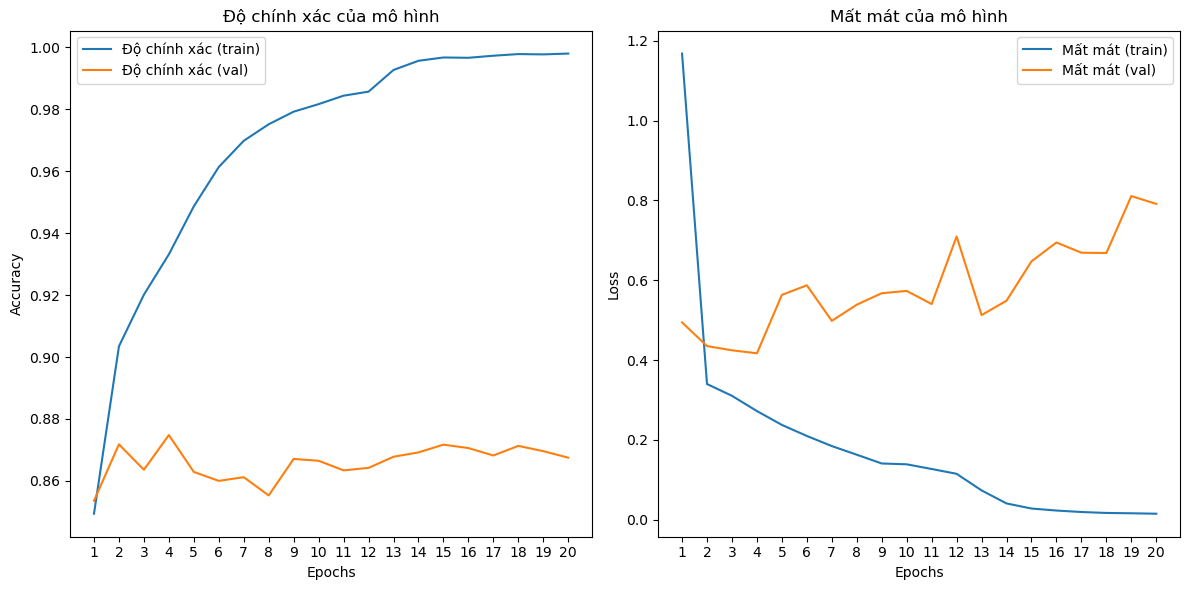

In [26]:
# Độ chính xác của mô hình
print(f"Độ chính xác của mô hình trên tập huấn luyện: {his.history['accuracy'][-1] * 100:.2f}%")
print(f"Độ chính xác của mô hình trên tập kiểm tra val: {his.history['val_accuracy'][-1] * 100:.2f}%")

epochs = range(1, len(his.history['accuracy']) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, his.history['accuracy'], label='Độ chính xác (train)')
plt.plot(epochs, his.history['val_accuracy'], label='Độ chính xác (val)')
plt.title('Độ chính xác của mô hình')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, his.history['loss'], label='Mất mát (train)')
plt.plot(epochs, his.history['val_loss'], label='Mất mát (val)')    
plt.title('Mất mát của mô hình')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Độ chính xác của model: 87.73%


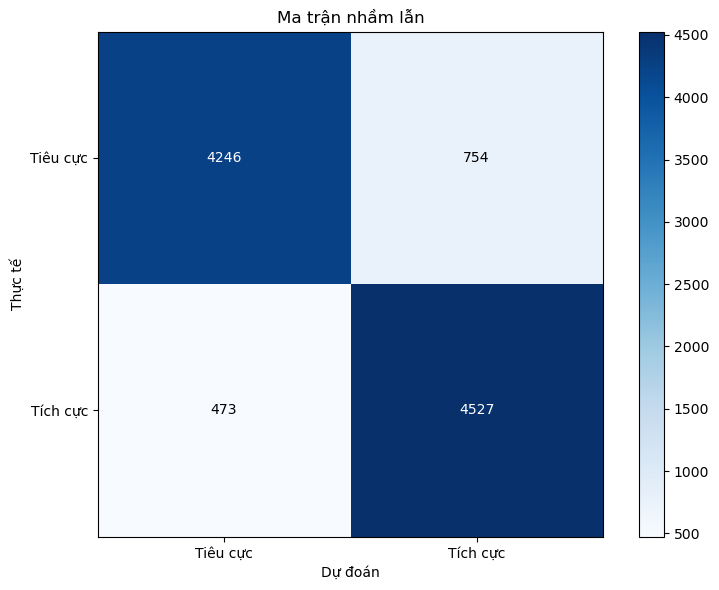

In [27]:
# vẽ ma trận nhầm lẫn
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model  # type: ignore

model = load_model('best_model.h5')

yred = deep_model.predict(X_test_tfidf)
yred = (yred > 0.5).astype(int)

# độ chính xác trên tập kiểm tra
acc_test = accuracy_score(y_test, yred)
print(f"Độ chính xác của model: {acc_test* 100:.2f}%")

cm = confusion_matrix(y_test, yred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn')
plt.colorbar()

# Thêm số liệu vào các ô
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Chỉ cần định nghĩa labels một lần
labels = ['Tiêu cực', 'Tích cực']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# Machine learning

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

machine_deep = SVC(C=1,
                   class_weight= None,
                   gamma='scale',
                   kernel='rbf'
                   )
machine_deep.fit(X_train_tfidf, 
                 train_labels)
print('Độ chính xác của model trên tập train:', machine_deep.score(X_train_tfidf, train_labels))
print('Độ chính xác của model trên tập validation:', machine_deep.score(X_val_tfidf, val_labels))
kq_test = machine_deep.predict(X_test_tfidf)
acc_test = accuracy_score(test_labels, kq_test)
print('Độ chính xác của model trên tập test:', acc_test)


Độ chính xác của model trên tập train: 0.9736666666666667
Độ chính xác của model trên tập validation: 0.8862
Độ chính xác của model trên tập test: 0.8944


In [29]:
kq_test = machine_deep.predict(X_val_tfidf)
acc_test = accuracy_score(val_labels, kq_test)
print('Độ chính xác của model trên tập validation:', acc_test)

Độ chính xác của model trên tập validation: 0.8862


Độ chính xác của model: 88.62%


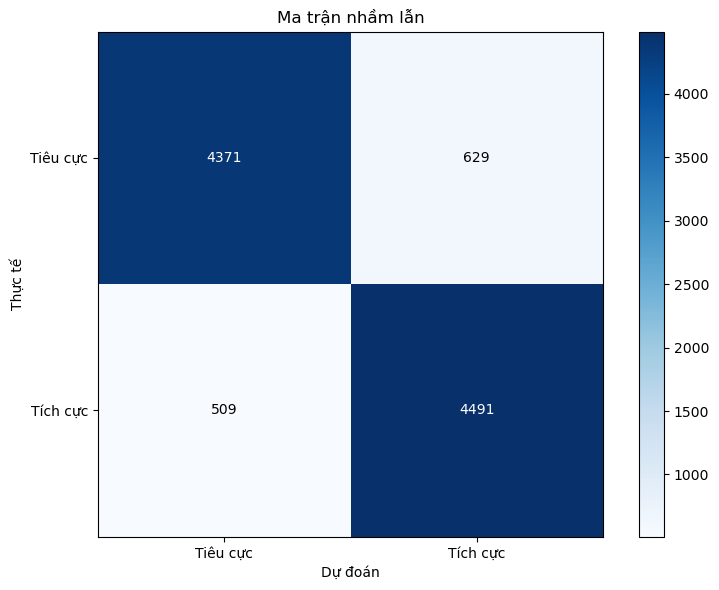

In [30]:
acc_test = accuracy_score(y_test, kq_test)
print(f"Độ chính xác của model: {acc_test* 100:.2f}%")

cm = confusion_matrix(y_test, kq_test)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn')
plt.colorbar()

# Thêm số liệu vào các ô
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Chỉ cần định nghĩa labels một lần
labels = ['Tiêu cực', 'Tích cực']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

In [31]:
import joblib

joblib.dump(machine_deep, 'MODEL/machine_deep.sav')

['MODEL/machine_deep.sav']

In [32]:
from tensorflow.keras.models import load_model  # type: ignore
import joblib

model1 = load_model('MODEL/deep(Nhận diện tốt nhất)IF-IDF.h5')
model2 = joblib.load('MODEL/machine_deep.sav')
a = input('Nhập comment của bạn: ')
print('Comment ban đầu:',a)
a = clean_text(a)
print('Comment sau khi xử lý:',a)

# a = tokenizer.texts_to_sequences([a])
# print('Comment sau khi chuyển đổi thành chuỗi:', a)
# # Pad sequence to match training data length
# a = pad_sequences(a, maxlen=100, padding='post', truncating='post')
# print('Comment sau khi padding:', a)

a = vectorizer.transform([a])
print('Comment sau khi chuyển đổi thành ma trận TF-IDF:', a.toarray())

pred = model1.predict(a)
if pred[0][0] > 0.5:
    print('Comment này được phân loại là: Tích cực')
    confidence = pred[0][0] * 100
else:
    print('Comment này được phân loại là: Tiêu cực')
    confidence = (1 - pred[0][0]) * 100
print("Độ tin cậy:", f"{confidence:.2f}%")

kq_test = model2.predict(a)
if kq_test[0] == 1:
    print('Comment này được phân loại là: Tích cực')
else:
    print('Comment này được phân loại là: Tiêu cực')

Comment ban đầu: quán này phục vụ nhiệt tình đến mức sợ luôn , khách nói tí thì chửi đánh luôn , sợ 
Comment sau khi xử lý: quán này phục_vụ nhiệt_tình đến mức sợ luôn khách nói tí thì chửi đánh luôn sợ
Comment sau khi chuyển đổi thành ma trận TF-IDF: [[0. 0. 0. ... 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Comment này được phân loại là: Tiêu cực
Độ tin cậy: 77.81%
Comment này được phân loại là: Tích cực


# Test model

### Câu chê:
"Thật sự thất vọng với nhà hàng này khi mọi thứ từ dịch vụ đến chất lượng món ăn đều không đạt kỳ vọng. Không gian quán tuy rộng rãi nhưng lại thiếu sự chăm chút, bàn ghế sắp xếp lộn xộn và không sạch sẽ. Món ăn thì nhạt nhẽo, không có gì đặc sắc, thậm chí một số món còn có cảm giác không tươi mới. Nhân viên phục vụ thiếu chuyên nghiệp, thái độ không thân thiện và thời gian chờ đợi món quá lâu. Với mức giá cao như vậy, tôi nghĩ rằng nhà hàng cần cải thiện rất nhiều để xứng đáng với sự kỳ vọng của khách hàng."

Thật sự 😞 thất vọng vs quán này 👉 https://bit.ly/xyz123 … mọi thứ từ dv 🥲 tới món ăn đều ko đạt 😑. Không gian rộng mà bày biện lộn xộn, bàn ghế còn dính bẩn 🤢. Đồ ăn thì nhạt toẹt, vài món thấy còn ko tươi. Nv thì kiểu khó chịu, gọi 3-4 lần mới ra. Đợi dài cả cổ ⏳. Với giá 💸 như này thì quá chát, chắc chắn ko quay lại 👎.

quán này phục vụ nhiệt tình đến mức sợ luôn , khách nói tí thì chửi đánh luôn , sợ 

### Câu khen:
"Nhà hàng này thực sự là một trải nghiệm ẩm thực đỉnh cao, từ cách bài trí không gian sang trọng, tinh tế cho đến hương vị món ăn được chế biến một cách tỉ mỉ, cầu kỳ. Mỗi món ăn như một tác phẩm nghệ thuật, không chỉ ngon miệng mà còn đẹp mắt, khiến thực khách không thể không trầm trồ. Đội ngũ nhân viên phục vụ chuyên nghiệp, luôn niềm nở và sẵn sàng đáp ứng mọi yêu cầu, tạo cảm giác thoải mái và dễ chịu. Đây chắc chắn là một địa điểm lý tưởng để thưởng thức ẩm thực và tận hưởng những khoảnh khắc đáng nhớ."

Nhà hàng này đúng là trải nghiệm 5⭐ đỉnh thật 😍👉 https://goo.gl/abc456. Không gian sang xịn mịn ✨, bài trí tinh tế. Món ăn thì cực kỳ ngon, trình bày đẹp mắt như nghệ thuật 🎨, ăn vừa ngon vừa thích mắt. Nv phục vụ thì siêu dễ thương 😊, nhiệt tình khỏi chê, hỏi gì cũng hỗ trợ liền. Đi 1 lần là mê, chắc chắn recommend 👍🔥.
